<font color = 'blue'>
Content: 

1. [Thanks to Kaggle Community as Introduction](#1)
2. [Load Python Pakages and Data](#2)
3. [First look to data](#3)
4. [Exploratory Data Analysis](#4)   
5. [Feature Engineering](#5)   
6. [Preprocesing](#6)
   * [Tree preprocessor](#7)
   * [Linear preprocessor](#8)
   * [A custom pipeline for Feature Engineering](#9)
7. [Putting pieces together](#10)
8. [Modeling and hyperparameter tuning](#11)
    * [Elasticnet example](#12)
    * [All tunned regressors](#13)
9. [Stacking](#14)
10. [Submission](#15)
11. [Appendix](#16)
    * [Notes](#17)
    * [Optuna tuning settings for different models](#18)


<a id = "1"></a><br>
# Thanks to Kaggle Community as Introduction

I tried to apply what I have learned so far, and it became one of the best-performing notebooks. It would not be possible without the Kaggle community's generous knowledge share. I tried many things, which include inspirations from others' works or using directly their codeblocks. 

Special thanks to the following notebooks and their owners:

* To ERTUĞRUL DEMIR for a cristal clear workflow - https://www.kaggle.com/code/datafan07/top-1-approach-eda-new-models-and-stacking 
* To GUNES EVITAN for his art-like visualizations - https://www.kaggle.com/code/gunesevitan/house-prices-advanced-stacking-tutorial
* To LUCA BASANISI for the best tutorial on the entire internet for pipelines https://www.kaggle.com/code/lucabasa/understand-and-use-a-pipeline/notebook
* To Wojciech Sylwester for a good baseline with a single regressor  https://www.kaggle.com/code/wojteksy/housing-prices-pipelines-custom-transformer



This notebook benefits best preprocessing and feature engineering practices posted by the community, and differentiates itself with the followings:

* 1- Almost an obsession about doing everything in a pipeline, including feature engineering, preprocessing, and hyperparameter tuning
* 2- An aggressive hyperparameter search for ensemble models with Optuna package
* 3- Add some extra features not included in others' works

Let's get started...



<a id = "2"></a><br>
# Load Python Pakages


In [1]:
#basics
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")


#preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer, quantile_transform


#statistics
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import randint

#feature engineering
from sklearn.feature_selection import mutual_info_regression


#transformers and pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config


#algorithms
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.svm import SVR


#model evaluation
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice


#stacking
from sklearn.ensemble import StackingRegressor


<a id = "3"></a><br>
#  First look to data

In [2]:
# Read the data
original_train_df = pd.read_csv('../input/home-data-for-ml-course/train.csv', index_col='Id')
original_test_df = pd.read_csv('../input/home-data-for-ml-course/test.csv', index_col='Id')

# reserved for pipeline
pipe_data = original_train_df.copy()
pipe_test = original_test_df.copy()

# use for preliminary analysis
train_df = original_train_df.copy()
test_df = original_test_df.copy()
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Descpriptive statistics for numerical and categorical data

In [3]:
#numerical feature descriptive statistics
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0


In [4]:
#categorical feature descriptive statistics

train_df.describe(include='object').T.sort_values(by=['unique'], ascending=False)

,count,unique,top,freq
Neighborhood,1460,25,NAmes,225
Exterior2nd,1460,16,VinylSd,504
Exterior1st,1460,15,VinylSd,515
SaleType,1460,9,WD,1267
Condition1,1460,9,Norm,1260
Condition2,1460,8,Norm,1445
HouseStyle,1460,8,1Story,726
RoofMatl,1460,8,CompShg,1434
Functional,1460,7,Typ,1360
BsmtFinType2,1422,6,Unf,1256


## Missing values

In [5]:
missing = pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False))
missing.columns = ["count"]
missing = missing.loc[(missing!=0).any(axis=1)]
missing["percent"] = missing[0:] / 1460
missing.style.background_gradient('viridis')

,count,percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


As you see from the above summary, we have many missing entries. If you read the data summary (https://www.kaggle.com/competitions/home-data-for-ml-course/data)what you will see that all the missing values are on purpose. These houses just don't have stated features.

We will take care of missing values as following:
* Fill all missing entries in numerical features with 0
* Fill all missing entries in categorical features with 'Do_not_have_this_feature'

We will do this imputations in our pipeline, for now let's just keep going...

## Grouping features for preprocessing purposes

Different data types will require different preprocessing techniques. Here, I will group features for bookkeeping and preprocessing purposes.

In [6]:
#Group features for preprocessing purpose
categorical_features = [feature for feature in train_df.columns if
                    train_df[feature].dtype == "object"] 

#from data set description
nominal_features = ["MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1", "Condition2", 
                    "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating",
                    "CentralAir", 'Electrical',"GarageType", "MiscFeature", "SaleType", "SaleCondition"]

ordinal_features = [ 'LotShape','Utilities','LandSlope','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
                    'BsmtFinType2','HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual',
                    'GarageCond','PavedDrive','PoolQC','Fence']



numerical_features = [feature for feature in train_df.columns if feature not in categorical_features + ['SalePrice']]

discrete_numerical_features = [ 'OverallQual','OverallCond','BsmtFullBath','BsmtHalfBath',
 'FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars','MoSold', "MSSubClass"] 

continuous_numerical_features = ['LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtFinSF2',
                                 'BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','GarageYrBlt',
                                 'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea',
                                 'MiscVal','YrSold']

#Just checking if any little feature left behind
assert categorical_features.sort() == (nominal_features + ordinal_features).sort()
assert numerical_features.sort() == (discrete_numerical_features + continuous_numerical_features).sort()

<a id = "4"></a><br>
# Exploratory Data Analysis

Let's obsorve how target variable changes with features.

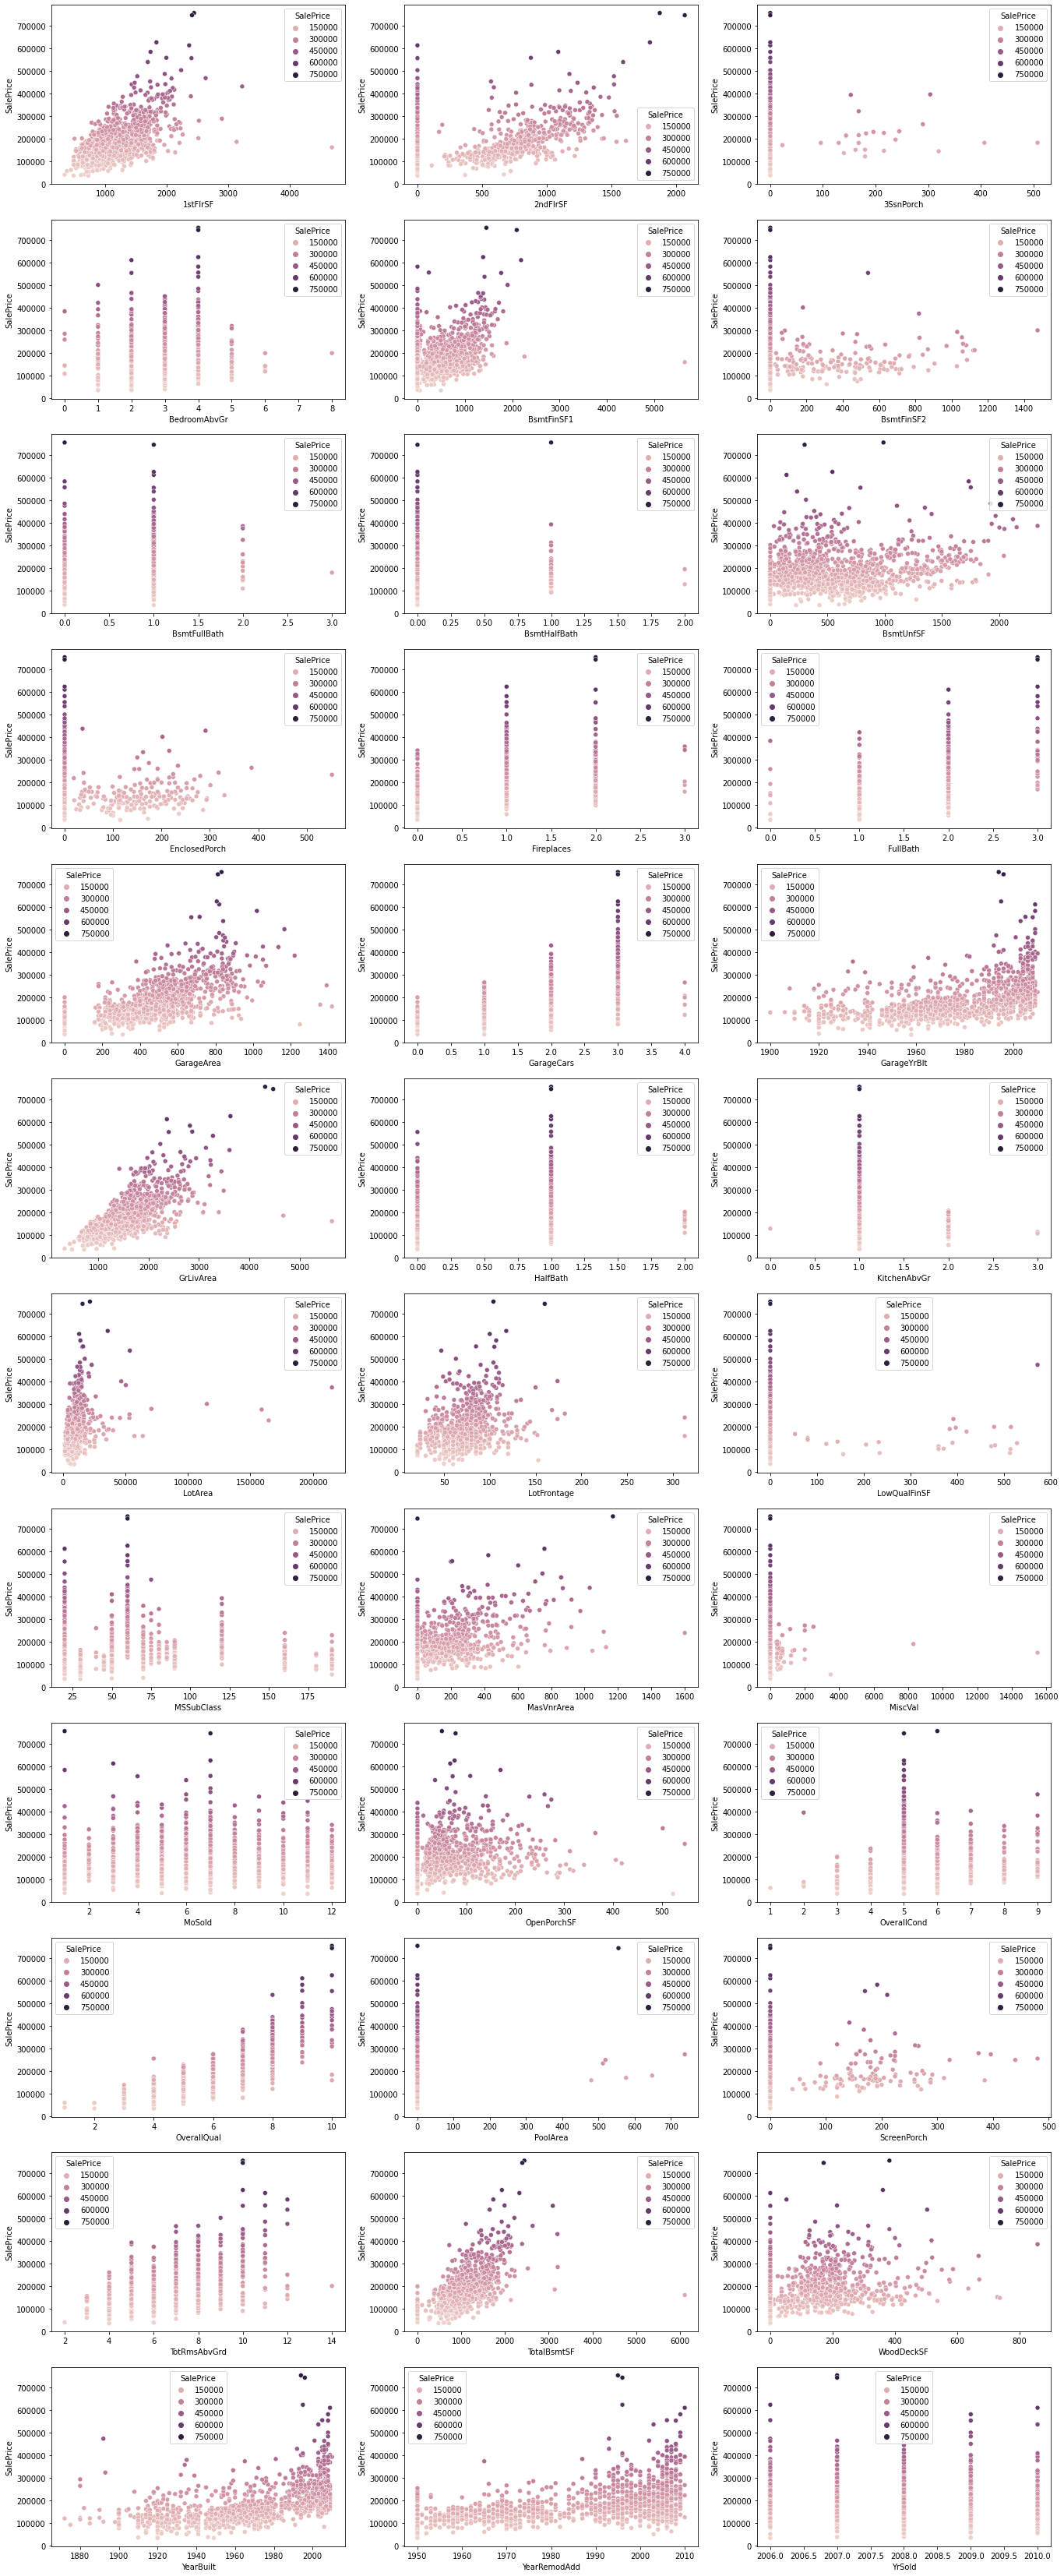

In [7]:
fig, ax = plt.subplots(12, 3, figsize=(23, 60))
for var, subplot in zip(numerical_features, ax.flatten()):
    sns.scatterplot(x=var, y='SalePrice',  data=train_df, ax=subplot, hue = 'SalePrice' )
    

Observations: 
* Basement, first floor, and second floor areas have a strong correlation with the target
* Overall quality also has a strong correlation
* There are some outliers in the data set. Let's drop them.

In [8]:

train_df = train_df.drop(train_df[(train_df['GrLivArea'] > 4000)
                                  & (train_df['SalePrice'] < 200000)].index)
train_df = train_df.drop(train_df[(train_df['GarageArea'] > 1200)
                                  & (train_df['SalePrice'] < 300000)].index)
train_df = train_df.drop(train_df[(train_df['TotalBsmtSF'] > 4000)
                                  & (train_df['SalePrice'] < 200000)].index)
train_df = train_df.drop(train_df[(train_df['1stFlrSF'] > 4000)
                                  & (train_df['SalePrice'] < 200000)].index)

train_df = train_df.drop(train_df[(train_df['TotRmsAbvGrd'] > 12)
                                  & (train_df['SalePrice'] < 230000)].index)
y = train_df.SalePrice

Let's look at correlations between features and the target with a more quantitative way..

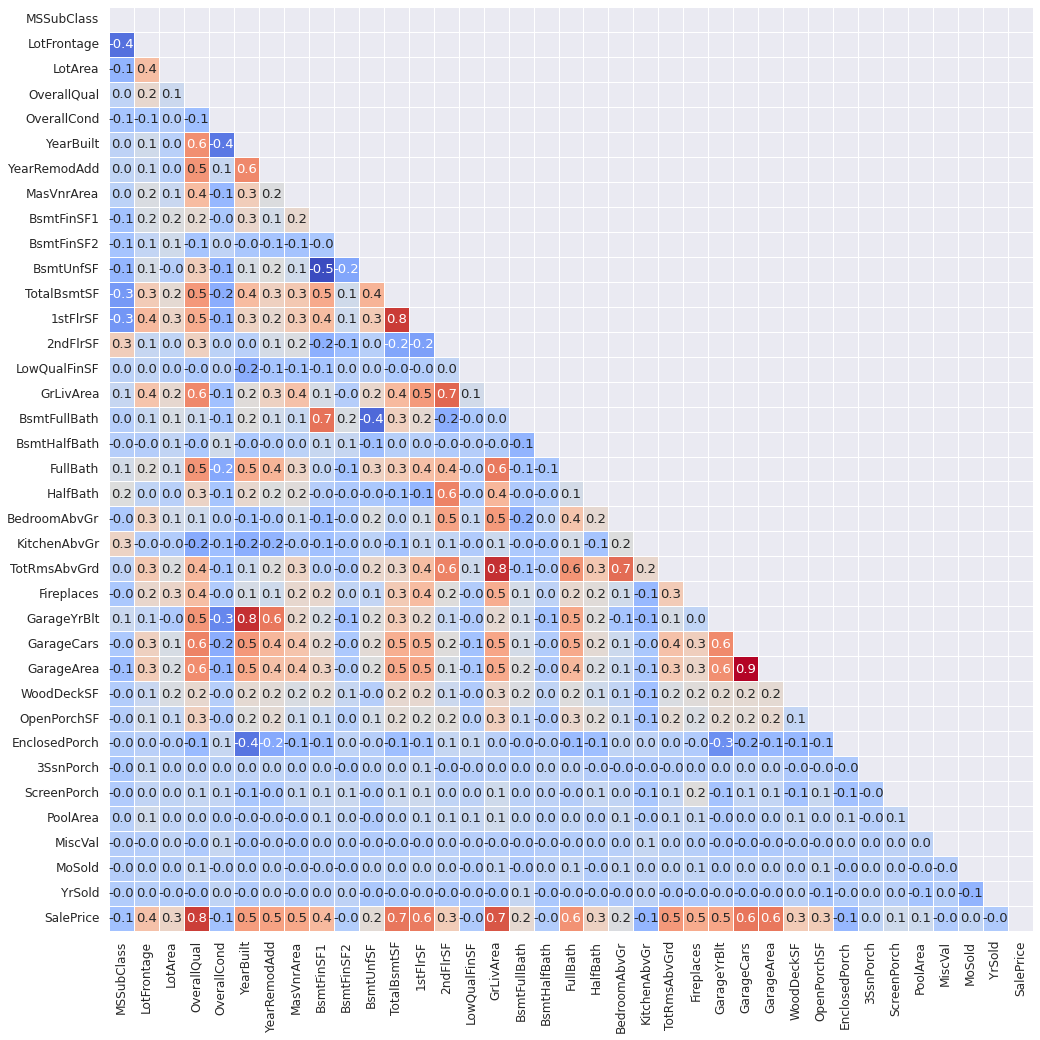

In [9]:
# Display correlations between numerical features and saleprice on heatmap.

sns.set(font_scale=1.1)
correlation_train = train_df.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(17, 17))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False);

There are many correlated features with the target. This is good news...

Correlation is a great measure to understand the relations between features and target variable. But it only measures linear relationships.

Mutual information is another measure, which also capable to measure more diverse relationships.

Note that these two measures only good at univariate analysis and they can not detect multivariate relationships.

Let's check mutual information for numerical features...


In [10]:

# determine the mutual information for numerical features
#You need to fillna to get results from mutual_info_regression function
mutual_df = train_df[numerical_features]

mutual_info = mutual_info_regression(mutual_df.fillna(0), y, random_state=1)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df.columns
pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] ).style.background_gradient("cool")


,Numerical_Feature_MI
OverallQual,0.570008
GrLivArea,0.489854
YearBuilt,0.381473
TotalBsmtSF,0.373381
GarageArea,0.373311
GarageCars,0.356887
1stFlrSF,0.312625
MSSubClass,0.281722
GarageYrBlt,0.260069
YearRemodAdd,0.255544


Mutual information also work with preprocessed categorical variables. Let's see which categorical features has strong relationship with the SalePrice..

In [11]:
mutual_df_categorical = train_df[categorical_features]
#categorical features must be encoded to get mutual information
for colname in mutual_df_categorical:
    mutual_df_categorical[colname], _ = mutual_df_categorical[colname].factorize()
mutual_info = mutual_info_regression(mutual_df_categorical.fillna("Do_not_have_feature"), y, random_state=1)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df_categorical.columns
pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Categorical_Feature_MI"] ).style.background_gradient("cool")


,Categorical_Feature_MI
ExterQual,0.334977
BsmtQual,0.332935
KitchenQual,0.330453
GarageFinish,0.264538
GarageType,0.209525
Foundation,0.204360
HeatingQC,0.176802
MSZoning,0.147618
Neighborhood,0.135474
MasVnrType,0.107934


Let's observe relationship between categorical variables with most mutual information scores and SalePrice. It could be seen that mean SalePrice is quite different for cotegories included in these features.

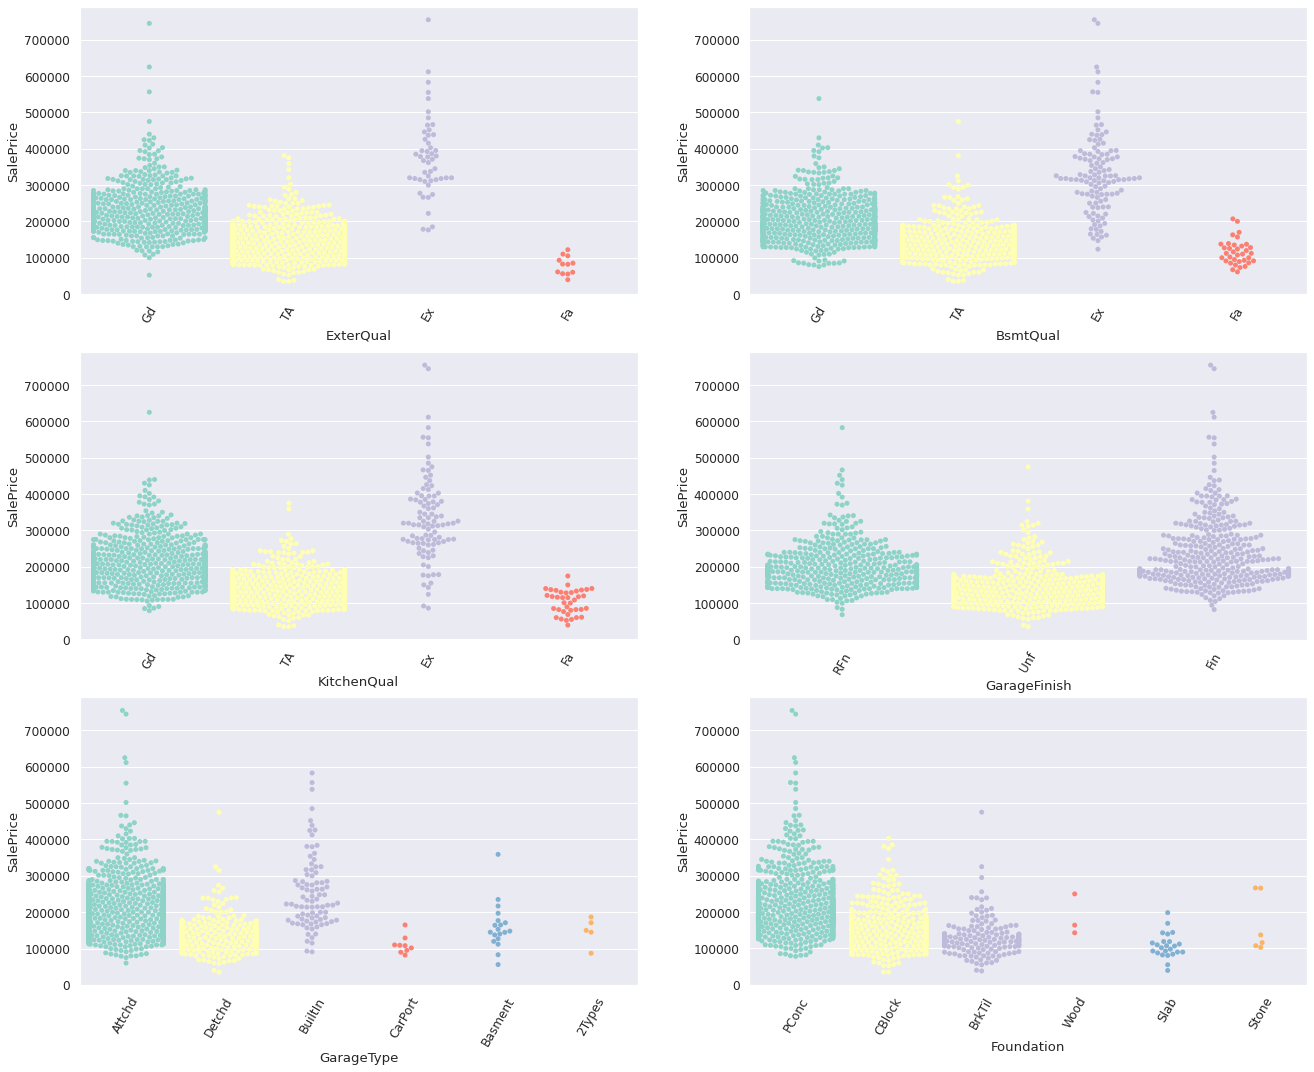

In [12]:
categorical_champions = ["ExterQual", "BsmtQual", "KitchenQual", "GarageFinish", "GarageType","Foundation"]    



fig, ax = plt.subplots(3, 2, figsize=(22, 18))
for var, subplot in zip(categorical_champions, ax.flatten()):    
    sns.swarmplot(x=var, y='SalePrice', data=train_df, ax=subplot, palette='Set3')
    for ax in fig.axes:
        plt.sca(ax)
        plt.xticks(rotation=60)
    

Let's also observe numerical features with high mutual information scores.

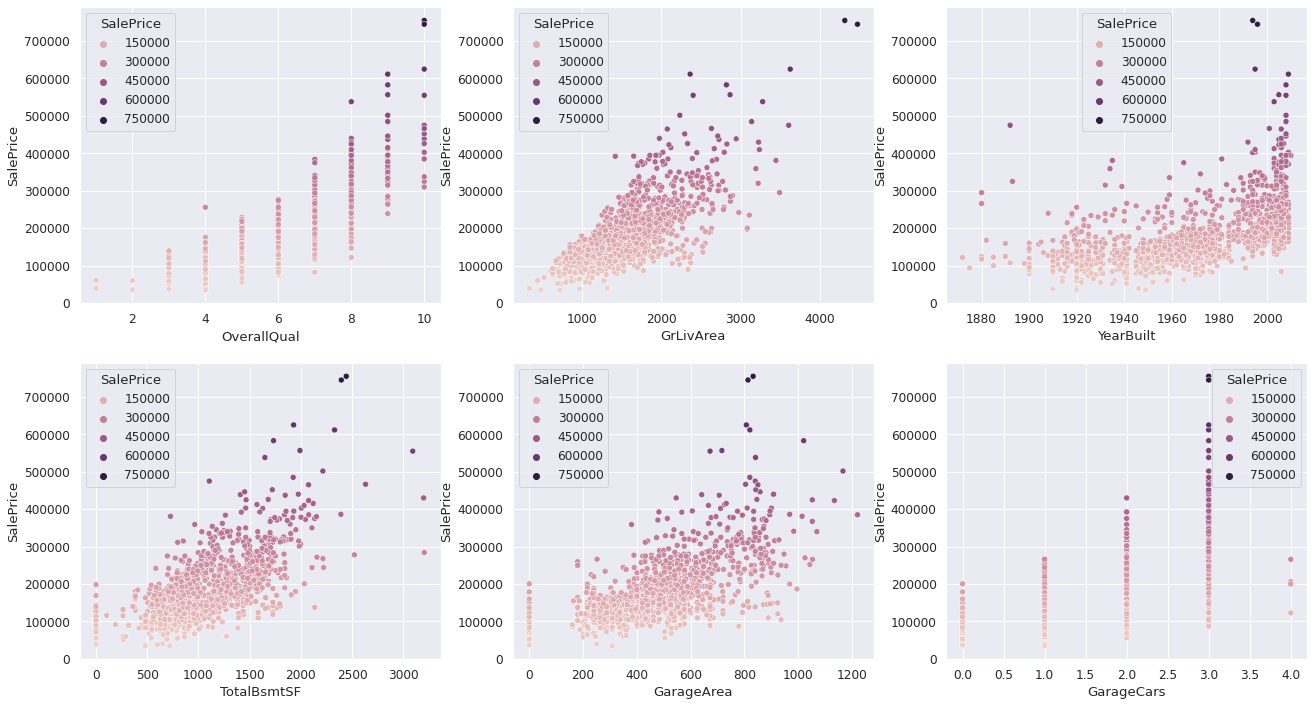

In [13]:
numerical_champions = ["OverallQual", "GrLivArea", "YearBuilt",  "TotalBsmtSF","GarageArea", "GarageCars"]

fig, ax = plt.subplots(2, 3, figsize=(22, 12))
for var, subplot in zip(numerical_champions, ax.flatten()):
    sns.scatterplot(x=var, y='SalePrice',  data=train_df, ax=subplot, hue = 'SalePrice')
    

<a id = "5"></a><br>
# Feature Engineering

ML algorithms have their own approaches to exploring multivariate relations within the data. But they are not capable to explore every relation by default. Think about regression models, they are just trying to optimize the coefficients of the features, but not interested in other arithmetical operations between features. Or tree-based models just focus to identify the best splitting points but are not interested in other things. So explicitly defining new features derived from the original features helps a lot. 

There are many additional features suggested by the Kaggle community. I add most of them and also add some new ones. They are listed below.

In [14]:
train_df["Lack_of_feature_index"] = train_df[["Street", "Alley", "MasVnrType", "GarageType", "MiscFeature",  'BsmtQual',
                                              'FireplaceQu','PoolQC','Fence']].isnull().sum(axis=1) + (train_df["MasVnrType"] == 'None')+ (train_df["CentralAir"] == 'No')
train_df ["MiscFeatureExtended"] = (train_df["PoolQC"].notnull()*1 + train_df["MiscFeature"].notnull()*1+ train_df["Fence"].notnull()*1).astype('int64')
train_df["Has_Alley"] = train_df["Alley"].notnull().astype('int64')
train_df["Lot_occupation"] = train_df["GrLivArea"]  / train_df["LotArea"]
train_df["Number_of_floors"] = (train_df["TotalBsmtSF"] != 0).astype('int64') + (train_df["1stFlrSF"] != 0).astype('int64') + (train_df["2ndFlrSF"] != 0).astype('int64')
train_df['Total_Close_Live_Area'] = train_df['GrLivArea'] + train_df['TotalBsmtSF'] 
train_df['Outside_live_area'] =  train_df['WoodDeckSF'] + train_df['OpenPorchSF'] + train_df['EnclosedPorch']+ train_df['3SsnPorch'] + train_df['ScreenPorch']
train_df['Total_usable_area'] = train_df['Total_Close_Live_Area'] + train_df['Outside_live_area']
train_df['Area_Quality_Indicator'] = train_df['Total_usable_area'] * train_df['OverallQual']
train_df['Area_Qual_Cond_Indicator'] = train_df['Total_usable_area'] * train_df['OverallQual']* train_df['OverallCond']
train_df['TotalBath'] = (train_df['FullBath'] + (0.5 * train_df['HalfBath']) + train_df['BsmtFullBath'] + (0.5 * train_df['BsmtHalfBath']))
train_df["Has_garage"] = train_df["GarageYrBlt"].notnull().astype('int64')
train_df['House_Age'] = train_df['YrSold'] - train_df['YearBuilt']
train_df["Is_Remodeled"] = (train_df["YearBuilt"] != train_df["YearRemodAdd"]).astype('int64')
train_df['HasBsmt'] = train_df['BsmtQual'].notnull().astype('int64')
train_df['Quality_conditition'] = train_df['OverallQual']* train_df['OverallCond']
train_df['Quality_conditition_2'] = train_df['OverallQual'] + train_df['OverallCond']
train_df['House_Age2'] = train_df['YrSold'] - train_df['YearRemodAdd']


new_features = list(set(train_df.columns) - set(categorical_features+numerical_features+['SalePrice']))
new_continuous_features= ["Lot_occupation", 'Total_Close_Live_Area', 'Outside_live_area', 'Total_usable_area','Area_Quality_Indicator', 'House_Age',  'Area_Qual_Cond_Indicator', 'Quality_conditition', 'House_Age2']
new_discrete_features = ["Lack_of_feature_index", "MiscFeatureExtended", "Has_Alley", "Number_of_floors", "Has_garage", "Is_Remodeled", 'TotalBath', 'HasBsmt', 'Quality_conditition_2'] 

assert new_features.sort() == (new_discrete_features + new_continuous_features).sort()


Let's check new features mutual information scores...

In [15]:
mutual_df = train_df[new_features]

mutual_info = mutual_info_regression(mutual_df.fillna(0), y, random_state=1)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df.columns
pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["New_Feature_MI"] ).style.background_gradient("cool")

,New_Feature_MI
Area_Quality_Indicator,0.935381
Area_Qual_Cond_Indicator,0.740554
Total_Close_Live_Area,0.670074
Total_usable_area,0.643080
Quality_conditition,0.438180
Quality_conditition_2,0.352191
TotalBath,0.348697
House_Age,0.342057
House_Age2,0.263028
Lack_of_feature_index,0.152748


Yeah... Some new features have higher mutual information scores than the original ones. This is definitely good news.

Let's also observe scatterplots. You will see high correlation between some of the new features and target varaible.

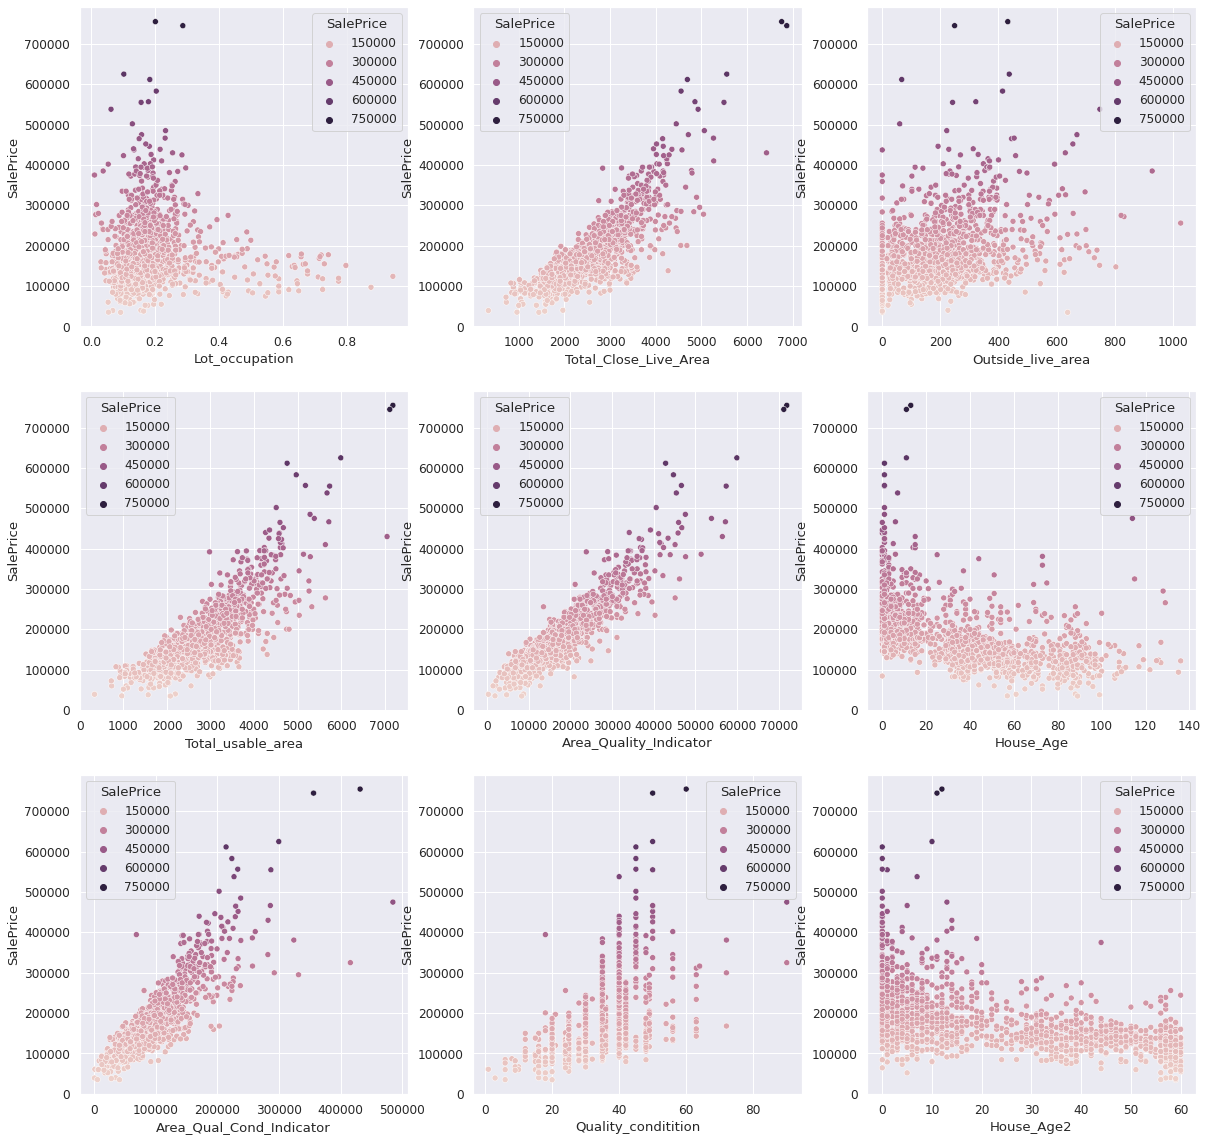

In [16]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
for var, subplot in zip(new_continuous_features, ax.flatten()):
    sns.scatterplot(x=var, y='SalePrice',  data=train_df, ax=subplot, hue = 'SalePrice')

Also some new categorical features work well. Mean of SalePrice is different for different cateories..

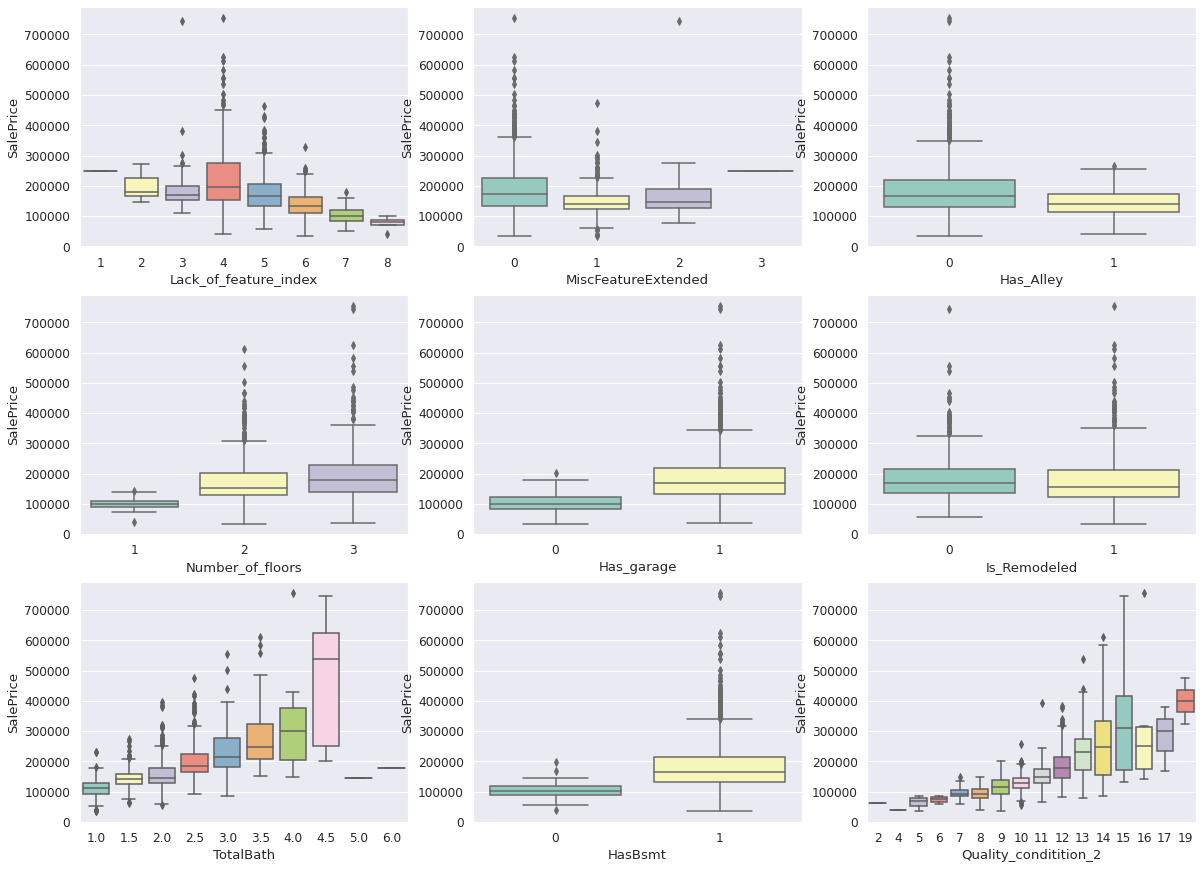

In [17]:
fig, ax = plt.subplots(3, 3, figsize=(20, 15))
for var, subplot in zip(new_discrete_features, ax.flatten()):
    sns.boxplot(x=var, y='SalePrice',  data=train_df, ax=subplot, palette='Set3')

In [18]:
### Update feature lists for bookkeeping
categorical_features = [feature for feature in train_df.columns if
                    train_df[feature].dtype == "object"]


ordinal_features = [ 'LotShape','Utilities','LandSlope','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
                    'BsmtFinType2','HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual',
                    'GarageCond','PavedDrive','PoolQC','Fence']




nominal_features = list(set(categorical_features) - set(ordinal_features)) 


numerical_features = list(set(train_df.columns) - set(categorical_features)) 

## Columns will be dropped

In preprocessing stage, I first decided to drop the following features. But it caused a slight score degradation. I decided to keep them. But note that dropping these columns could lead to a slight speed gain.

* No info columns: MoSold, BsmtFinSF2, 3SsnPorch, YrSold, Street, Condition2, PoolQC, Utilities

* Missing columns: PoolQC, MiscFeature, Alley, Fence

* Preprocessing decisions: FireplaceQu, GarageYrBlt, YearBuilt, YearRemodAdd

In [19]:
#columns_dropped = ["MoSold","BsmtFinSF2","3SsnPorch","YrSold","Street","Condition2","PoolQC","Utilities",
                   #"PoolQC","MiscFeature","Alley","Fence","FireplaceQu","GarageYrBlt","YearBuilt","YearRemodAdd"]

<a id = "6"></a><br>
# Preprocesing

Up to now we try to understand the data set and decided to create some new features. Remember that one of the primary goals of this notebook is to handle all preprocessing steps in the pipeline. Pipelines are great for the following reasons:

* They help to avoid any data leakage in stateful transformations which could eventually lead to overfitting. 
* There is no need for manual tracking of preprocessing steps in train and test sets
* You end up with a ready to the deployment model

Here, I will construct building blocks of preprocessing steps in a pipeline according to the following decisions:

#### Missing data handling:

* Impute missing values according to data description (i.e. fill all missing entries in numerical features with 0, in categorical features with 'Do_not_have_this_feature')

#### Categorical data processing:

* Use ordinal transformation for ordinal categorical features, use one-hot encoding for others

#### Numerical data processing:
* For linear models and support vector machines scale the features, and apply additional power transformation for skewed features. (power transformation is kept limited with continuous features)

* For tree-based models do not use any scaling since they do not require


#### Target varaible processing:
* For linear models and support vector machines use log transformation for target varaible. (TransformedTargetRegressor is very helpful)

#### Creating new features:

* Add a custom transformer in the pipeline to create new features


<a id = "7"></a><br>
## Tree preprocessor

Sklearn has many usefull functions for preprocessing. For missing value imputation and one-hot encoding I will use these built-in functions.
For ordinal encoding a little extra work required. 

In [20]:

# Preprocessing for numerical data

numerical_transformer = Pipeline(steps=[
    
    ('imputer', SimpleImputer(strategy='constant', fill_value = 0))
])
# Preprocessing for categorical data
nominal_transformer = Pipeline(steps=[
    
    ('imputer', SimpleImputer(strategy='constant', fill_value = 'Do_not_have_this_feature')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [21]:
GarageQual_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
Fence_map = {'GdPrv': 4,'MnPrv': 3,'GdWo': 2, 'MnWw': 1,'NA': 0}
GarageFinish_map = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'NA': 0}
KitchenQual_map = {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0}
GarageCond_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
HeatingQC_map = {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0}
ExterQual_map = {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0}
BsmtCond_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
LandSlope_map = {'Gtl': 2, 'Mod': 1, 'Sev': 0}
ExterCond_map = {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0}
BsmtExposure_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}
PavedDrive_map = {'Y': 2, 'P': 1, 'N': 0}
BsmtQual_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
LotShape_map = {'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0}
BsmtFinType2_map = {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1, 'NA': 0}
BsmtFinType1_map = {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1, 'NA': 0}
FireplaceQu_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
Utilities_map = {"AllPub":3, "NoSewr":2, "NoSeWa":1,  "ELO":0}
Functional_map = {'Typ': 7,'Min1': 6,'Min2': 5,'Mod': 4,'Maj1': 3,'Maj2': 2, 'Sev': 1 , 'Sal': 0}
PoolQC_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}

In [22]:
ordinal_mapping = [{'col': col, 'mapping': globals()[col + '_map']} 
                    for col in ordinal_features]

In [23]:
ordinal_transformer = ce.OrdinalEncoder(mapping = ordinal_mapping)

In [24]:
ordinal_transformer = Pipeline(steps=[
    

    ('ordinal_encoder', ce.OrdinalEncoder(mapping = ordinal_mapping))
])


Okay our building blocks are ready...Let's put them together. 

In [25]:
# Bundle preprocessing for tree-based algorithms
tree_preprocessor = ColumnTransformer(remainder=numerical_transformer,
    transformers=[

        
        ('nominal_transformer', nominal_transformer, nominal_features),
        ('ordinal_transformer', ordinal_transformer, ordinal_features),
        
            
    ])


set_config(display="diagram")
tree_preprocessor

ColumnTransformer(remainder=Pipeline(steps=[('imputer',
                                             SimpleImputer(fill_value=0,
                                                           strategy='constant'))]),
                  transformers=[('nominal_transformer',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='Do_not_have_this_feature',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Street', 'Exterior1st', 'MasVnrType',
                                  'Neighborhood', 'A...
                                                                                       'NA': 0,
                                                                                       'Po': 1,
                                                                                       'TA': 3}},
                                                                          {'col': 'Fence',
                                                                           'mapping': {'GdPrv': 4,
                                                                                       'GdWo': 2,
                                                                                       'MnPrv': 3,
                                                                                       'MnWw': 1,
                                                                                       'NA': 0}}]))]),
                                 ['LotShape', 'Utilities', 'LandSlope',
                                  'ExterQual', 'ExterCond', 'BsmtQual',
                                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'HeatingQC', 'KitchenQual',
                                  'Functional', 'FireplaceQu', 'GarageFinish',
                                  'GarageQual', 'GarageCond', 'PavedDrive',
                                  'PoolQC', 'Fence'])])

<a id = "8"></a><br>
## Linear preprocessor

For linear models and support vector machines, we need additional preprocessing for numerical data. Scaling numerical features and handling skewness helps both for performance and faster convergence. 

Also, target transformation helps to improve performance. We will do that in modeling by encapsulating our models by TransformedTargetRegressor.

In [26]:
# Preprocessing for numerical data
numerical_transformer2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value = 0)),
    ('Scaller', StandardScaler()),    
     
    
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    
    ('imputer', SimpleImputer(strategy='constant', fill_value = 'Do_not_have_this_feature')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

Since linear models have normality assumptions skewed features hurt their performance(at least in theory). So, we need to handle them. Let's observe the skewness of features.

In [27]:
skew_features = train_df.select_dtypes(exclude=['object']).skew().sort_values(ascending=False)
skew_features = pd.DataFrame({'Skew' : skew_features})
skew_features.style.background_gradient('rocket')

,Skew
MiscVal,24.455241
PoolArea,15.926839
LotArea,12.628557
3SsnPorch,10.282620
LowQualFinSF,9.249359
KitchenAbvGr,4.518137
BsmtFinSF2,4.245246
ScreenPorch,4.112351
BsmtHalfBath,4.093529
Has_Alley,3.639899


In [28]:
#Kept limited with continuous features
skewed_features = [
'MiscVal',  'PoolArea', 'LotArea', '3SsnPorch', 'LowQualFinSF', 'BsmtFinSF2', 'ScreenPorch',
 'EnclosedPorch','Lot_occupation','MasVnrArea','OpenPorchSF',
    'Area_Qual_Cond_Indicator','LotFrontage','WoodDeckSF','Area_Quality_Indicator','Outside_live_area']


In [29]:
skewness_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value = 0)),
    ('PowerTransformer', PowerTransformer( method='yeo-johnson', standardize=True)),      
])

In [30]:
# Bundle preprocessing for linear algorithms and SVR
linear_preprocessor = ColumnTransformer(remainder=numerical_transformer2,
    transformers=[
        ('skewness_transformer', skewness_transformer, skewed_features),
        ('nominal_transformer', nominal_transformer, nominal_features),
        ('ordinal_transformer', ordinal_transformer, ordinal_features),

    ])

linear_preprocessor

ColumnTransformer(remainder=Pipeline(steps=[('imputer',
                                             SimpleImputer(fill_value=0,
                                                           strategy='constant')),
                                            ('Scaller', StandardScaler())]),
                  transformers=[('skewness_transformer',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('PowerTransformer',
                                                  PowerTransformer())]),
                                 ['MiscVal', 'PoolArea', 'LotArea', '3SsnPorch',
                                  'LowQualFinSF',...
                                                                                       'NA': 0,
                                                                                       'Po': 1,
                                                                                       'TA': 3}},
                                                                          {'col': 'Fence',
                                                                           'mapping': {'GdPrv': 4,
                                                                                       'GdWo': 2,
                                                                                       'MnPrv': 3,
                                                                                       'MnWw': 1,
                                                                                       'NA': 0}}]))]),
                                 ['LotShape', 'Utilities', 'LandSlope',
                                  'ExterQual', 'ExterCond', 'BsmtQual',
                                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'HeatingQC', 'KitchenQual',
                                  'Functional', 'FireplaceQu', 'GarageFinish',
                                  'GarageQual', 'GarageCond', 'PavedDrive',
                                  'PoolQC', 'Fence'])])

<a id = "9"></a><br>
## A custom pipeline for Feature Engineering

Sklearn has many built-in functions to create pipelines. However, for problem-specific needs, you may need to create custom ones. Sklearn allows this by inheriting base classes (BaseEstimator, TransformerMixin) or using FunctionTransformer. FunctionTransformer is a more convenient way however it is only suitable for stateless transformations(i.e. transformations that do not depend on any distribution in the data set). 

Here, I used the first method. If you are not familiar with custom pipelines please read (https://www.kaggle.com/code/lucabasa/understand-and-use-a-pipeline/notebook)

In [31]:
class FeatureCreator1(BaseEstimator, TransformerMixin):
    def __init__(self, add_attributes=True):
        
        self.add_attributes = add_attributes
        
    def fit(self, X, y=None):
        
        return self
    
    def transform(self, X):
        
        if self.add_attributes:
            X_copy = X.copy()
            X_copy["Lack_of_feature_index"] = X_copy[["Street", "Alley", "MasVnrType", "GarageType", "MiscFeature",  'BsmtQual',
                                              'FireplaceQu','PoolQC','Fence']].isnull().sum(axis=1) + (X_copy["MasVnrType"] == 'None')+ (X_copy["CentralAir"] == 'No')
            X_copy["MiscFeatureExtended"] = (X_copy["PoolQC"].notnull()*1 + X_copy["MiscFeature"].notnull()*1+ X_copy["Fence"].notnull()*1).astype('int64')
            X_copy["Has_Alley"] = X_copy["Alley"].notnull().astype('int64')
            X_copy["Lot_occupation"] = X_copy["GrLivArea"]  / X_copy["LotArea"]
            X_copy["Number_of_floors"] = (X_copy["TotalBsmtSF"] != 0).astype('int64') + (X_copy["1stFlrSF"] != 0).astype('int64') + (X_copy["2ndFlrSF"] != 0).astype('int64')
            X_copy['Total_Close_Live_Area'] = X_copy['GrLivArea'] + X_copy['TotalBsmtSF'] 
            X_copy['Outside_live_area'] =  X_copy['WoodDeckSF'] + X_copy['OpenPorchSF'] + X_copy['EnclosedPorch']+ X_copy['3SsnPorch'] + X_copy['ScreenPorch']
            X_copy['Total_usable_area'] = X_copy['Total_Close_Live_Area'] + X_copy['Outside_live_area']
            X_copy['Area_Quality_Indicator'] = X_copy['Total_usable_area'] * X_copy['OverallQual']
            X_copy['Area_Qual_Cond_Indicator'] = X_copy['Total_usable_area'] * X_copy['OverallQual']* X_copy['OverallCond']
            X_copy['TotalBath'] = (X_copy['FullBath'] + (0.5 * X_copy['HalfBath']) + X_copy['BsmtFullBath'] + (0.5 * X_copy['BsmtHalfBath']))
            X_copy["Has_garage"] = X_copy["GarageYrBlt"].notnull().astype('int64')
            X_copy['House_Age'] = X_copy['YrSold'] - X_copy['YearBuilt']
            X_copy["Is_Remodeled"] = (X_copy["YearBuilt"] != X_copy["YearRemodAdd"]).astype('int64')
            X_copy['HasBsmt'] = X_copy['BsmtQual'].notnull().astype('int64')
            X_copy['Quality_conditition'] = X_copy['OverallQual']* X_copy['OverallCond']
            X_copy['Quality_conditition_2'] = X_copy['OverallQual'] + X_copy['OverallCond']
            X_copy['House_Age2'] = X_copy['YrSold'] - X_copy['YearRemodAdd']
            X_copy['Quality_conditition'] = X_copy['OverallQual']* X_copy['OverallCond']
            X_copy['Quality_conditition_2'] = X_copy['OverallQual'] + X_copy['OverallCond']
            X_copy['House_Age2'] = X_copy['YrSold'] - X_copy['YearRemodAdd']
            return X_copy
        else:
            return X_copy

In [32]:
Creator1 = FeatureCreator1(add_attributes = True)

<a id = "10"></a><br>
# Putting pieces together

Okay... We created the necessary pieces for a pipeline. Let's put everything together.

* Some new features specifically count 'NA's. That is why I will put the feature creator on the top of everything(before any imputation).
* It will be followed by a preprocessor block
* Finally, we will attach an regression algorithm at the end

Let's create a pipeline and visualize it.

In [33]:
pipe_xgb = Pipeline(steps=[
                        ('Creator1', Creator1),
                       ('tree_preprocessor', tree_preprocessor),
                      ('regressor1', XGBRegressor(random_state =1)),
                     ])
pipe_xgb

Pipeline(steps=[('Creator1', FeatureCreator1()),
                ('tree_preprocessor',
                 ColumnTransformer(remainder=Pipeline(steps=[('imputer',
                                                              SimpleImputer(fill_value=0,
                                                                            strategy='constant'))]),
                                   transformers=[('nominal_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Do_not_have_this_feature',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown...
                              gamma=None, gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=None,
                              max_leaves=None, min_child_weight=None,
                              missing=nan, monotone_constraints=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, predictor=None,
                              random_state=1, reg_alpha=None, reg_lambda=None, ...))])

For linear models we will have an additional target transformation. I will use TransformedTargetRegressor to encapsulate our pipeline.
Let's observe an example. 

In [34]:
pipe_Lasso = Pipeline(steps=[
                       ('Creator1', Creator1),
                       ('linear_preprocessor', linear_preprocessor),
                      ('regressor2', Lasso()),
                     ])

TargetTransformedLasso = TransformedTargetRegressor(regressor=pipe_Lasso, func=np.log1p, inverse_func=np.expm1)
TargetTransformedLasso

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('Creator1',
                                                      FeatureCreator1()),
                                                     ('linear_preprocessor',
                                                      ColumnTransformer(remainder=Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(fill_value=0,
                                                                                                                 strategy='constant')),
                                                                                                  ('Scaller',
                                                                                                   StandardScaler())]),
                                                                        transformers=[('skewness_transformer',
                                                                                       Pipeline(steps=[('impu...
                                                                                                                                {'col': 'Fence',
                                                                                                                                 'mapping': {'GdPrv': 4,
                                                                                                                                             'GdWo': 2,
                                                                                                                                             'MnPrv': 3,
                                                                                                                                             'MnWw': 1,
                                                                                                                                             'NA': 0}}]))]),
                                                                                       ['LotShape',
                                                                                        'Utilities',
                                                                                        'LandSlope',
                                                                                        'ExterQual',
                                                                                        'ExterCond',
                                                                                        'BsmtQual',
                                                                                        'BsmtCond',
                                                                                        'BsmtExposure',
                                                                                        'BsmtFinType1',
                                                                                        'BsmtFinType2',
                                                                                        'HeatingQC',
                                                                                        'KitchenQual',
                                                                                        'Functional',
                                                                                        'FireplaceQu',
                                                                                        'GarageFinish',
                                                                                        'GarageQual',
                                                                                        'GarageCond',
                                                                                        'PavedDrive',
                                                                                        'PoolQC',
                                

Okay...We are almost ready to start the modeling. Before moving on we will make first touch with the data that we reserved for the pipeline. I will drop outliers and update the feature list. Any preprocessing step, excluding outlier removal, will be taken care of in pipeline.

In [35]:
#Drop outliers
pipe_data = pipe_data.drop(pipe_data[(pipe_data['GrLivArea'] > 4000)
                                 & (pipe_data['SalePrice'] < 200000)].index)
pipe_data = pipe_data.drop(pipe_data[(pipe_data['GarageArea'] > 1200)
                                & (pipe_data['SalePrice'] < 300000)].index)
pipe_data = pipe_data.drop(pipe_data[(pipe_data['TotalBsmtSF'] > 4000)
                               & (pipe_data['SalePrice'] < 200000)].index)
pipe_data = pipe_data.drop(pipe_data[(pipe_data['1stFlrSF'] > 4000)
                                  & (pipe_data['SalePrice'] < 200000)].index)

pipe_data = pipe_data.drop(pipe_data[(pipe_data['TotRmsAbvGrd'] > 12)
                                  & (pipe_data['SalePrice'] < 230000)].index)

y = pipe_data.SalePrice
pipe_data = pipe_data.drop("SalePrice", axis=1)


In [36]:
### Update feature lists
categorical_features = [feature for feature in pipe_data.columns if
                    pipe_data[feature].dtype == "object"]


ordinal_features = [ 'LotShape','Utilities','LandSlope','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
                    'BsmtFinType2','HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual',
                    'GarageCond','PavedDrive','PoolQC','Fence']




nominal_features = list(set(categorical_features) - set(ordinal_features)) 


numerical_features = list(set(pipe_data.columns) - set(categorical_features)) 

<a id = "11"></a><br>
# Modeling and hyperparameter tuning

I used the Optuna package for hyperparameter tuning. I use single-stage tuning for linear models. For the ensembles, I made some iterations by enlarging or shrinking the hyperparameter space according to findings in previous iterations.

I will just demonstrate one example with elasticnet regressor here. I put the code blocks in the appendix for other algorithms for those who may need them.

In [37]:
import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

<a id = "12"></a><br>
## Elasticnet example

In [38]:
def objective(trial):

    max_iter = trial.suggest_int("max_iter", 1000, 4000)
    alpha =  trial.suggest_float("alpha", 1e-4, 1000, log=True) 
    l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0, step=0.05)
    tol =  trial.suggest_float("tol", 1e-6, 1e-3, log=True)

    
    
    ElasticNet_regressor = ElasticNet(max_iter=max_iter, alpha=alpha,tol=tol, l1_ratio=l1_ratio, random_state =1)
   
    # -- Make a pipeline
    ElasticNet_pipeline = make_pipeline(Creator1,linear_preprocessor, ElasticNet_regressor)
    
    ElasticNet_model = TransformedTargetRegressor(regressor=ElasticNet_pipeline, func=np.log1p, inverse_func=np.expm1)
    
    ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0) #ShuffleSplit will help you to keep distributions of training data and folds similar)
    score = cross_val_score(ElasticNet_model, pipe_data, y, scoring= make_scorer(mean_absolute_error),  cv=ss)
    score = score.mean()
    return score


sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2022-12-15 17:55:08,825] A new study created in memory with name: no-name-0e1189ce-7041-4979-b751-e2aaa5c1d858
[I 2022-12-15 17:55:10,927] Trial 0 finished with value: 55030.748732463035 and parameters: {'max_iter': 2123, 'alpha': 451.8560951024097, 'l1_ratio': 0.75, 'tol': 6.251373574521755e-05}. Best is trial 0 with value: 55030.748732463035.
[I 2022-12-15 17:55:15,653] Trial 1 finished with value: 12839.925662553796 and parameters: {'max_iter': 1468, 'alpha': 0.0012358382772306934, 'l1_ratio': 0.05, 'tol': 0.0003967605077052988}. Best is trial 1 with value: 12839.925662553796.
[I 2022-12-15 17:55:24,628] Trial 2 finished with value: 24857.885332020767 and parameters: {'max_iter': 2803, 'alpha': 9.047071957568372, 'l1_ratio': 0.0, 'tol': 0.0008123245085588687}. Best is trial 1 with value: 12839.925662553796.
[I 2022-12-15 17:55:28,629] Trial 3 finished with value: 12886.766070494694 and parameters: {'max_iter': 3498, 'alpha': 0.003064599841241145, 'l1_ratio': 0.15000000000000002, 

I wanted to add some visualizations here.  They could easily generated by Optuna's visualization functions. They are very helpful in understanding the tuning process. 

In [39]:
plot_optimization_history(study)

History shows that at the begging of the tunning process there were some oscillations in objective value. But, finally, Optuna succeeded to find a good hyperparameter range, and oscillations settled down. We can conclude that any further iretations will not help a lot.

In [40]:
plot_slice(study)

In [41]:
plot_contour(study)

Slice and contour plots are very useful to understand which parameter works well in which range. It could be observed that lower alpha and tol generally work fine.

In [42]:
plot_param_importances(study)

I think the most useful plot is the parameter importance plot and its quite self-explanatory.

<a id = "13"></a><br>
## All tunned regressors

Well! I tunned all regressors similar to elasticnet. Let's list tunned versions of them with found hyperparameters. Note that I only tunned the algorithm specific parameters you could also tune other parameters in pipeline. (ex. type of scalling or different imputation methods)

I dropped the feature creator part here. I will add it back in later. (I'm not sure but I feel like feeding regressors from a single featurecreator could help for speed increase. If you have a comment please do not hesitate to share)

In [43]:
xgb_tunned = XGBRegressor(n_estimators = 6500,
                          alpha = 1.7938525031017074e-09,
                          subsample = 0.3231512729662032,
                          colsample_bytree = 0.25528017285233484,
                          max_depth = 5, 
                          min_child_weight = 2, 
                          learning_rate = 0.004828231865923587, 
                          gamma = 0.0026151163125498213,
                          random_state =1)

pipe_xgb = Pipeline(steps=[
                        
                       ('tree_preprocessor', tree_preprocessor),
                       ('regressor1', xgb_tunned),
                     ])



gbm_tunned = GradientBoostingRegressor(n_estimators= 5500,
                                       max_depth=5,
                                       min_samples_leaf=14,
                                       learning_rate=0.006328507206504974, 
                                       subsample=0.9170443266552768,
                                       max_features='sqrt', 
                                       random_state=1)


pipe_gbm = Pipeline(steps=[
                       
                       ('tree_preprocessor', tree_preprocessor),
                      ('regressor2', gbm_tunned),
                     ])

lgbm_tunned = LGBMRegressor(n_estimators =7000,
                            max_depth = 7,
                            learning_rate =0.002536841439596437,
                            min_data_in_leaf =22, 
                            subsample= 0.7207500503954922, 
                            max_bin =210 ,
                            feature_fraction = 0.30010067215105635, 
                            random_state =1,
                            verbosity= -1)

pipe_lgbm = Pipeline(steps=[
                       
                       ('tree_preprocessor', tree_preprocessor),
                      ('regressor3', lgbm_tunned),
                     ])

catboost_tunned = CatBoostRegressor(iterations = 4500,
                                    colsample_bylevel =0.05367479984702603,
                                    learning_rate = 0.018477566955501026,random_strength = 0.1321272840705348,
                                    depth = 6,
                                    l2_leaf_reg = 4,
                                    boosting_type = 'Plain',
                                    bootstrap_type = 'Bernoulli', 
                                    subsample = 0.7629052520889268, 
                                    logging_level = 'Silent', 
                                    random_state =1)

pipe_catboost = Pipeline(steps=[
                       ('tree_preprocessor', tree_preprocessor),
                      ('regressor4', catboost_tunned),
                     ])



elasticnet_tunned = ElasticNet(max_iter= 3993,
                               alpha = 0.0007824887724782356,
                               l1_ratio= 0.25, 
                               tol = 3.78681184748232e-06, 
                               random_state= 1)

pipe_Elasticnet = Pipeline(steps=[
                       
                       ('linear_preprocessor', linear_preprocessor),
                      ('regressor5', elasticnet_tunned),
                     ])

TargetTransformedElasticnet = TransformedTargetRegressor(regressor=pipe_Elasticnet, func=np.log1p, inverse_func=np.expm1)


lasso_tunned = Lasso(max_iter= 2345,
                     alpha =0.00019885959230548468,
                     tol = 2.955506894549702e-05, 
                     random_state= 1)

pipe_Lasso = Pipeline(steps=[
                       
                       ('linear_preprocessor', linear_preprocessor),
                      ('regressor6', lasso_tunned),
                     ])


TargetTransformedLasso = TransformedTargetRegressor(regressor=pipe_Lasso, func=np.log1p, inverse_func=np.expm1)


ridge_tunned = Ridge(max_iter= 1537, 
                     alpha = 6.654338887411367,
                     tol = 8.936831872581897e-05, 
                     random_state= 1)

pipe_Ridge = Pipeline(steps=[
                       
                   ('linear_preprocessor', linear_preprocessor),
                      ('regressor7', ridge_tunned),
                     ])

TargetTransformedRidge = TransformedTargetRegressor(regressor=pipe_Ridge, func=np.log1p, inverse_func=np.expm1)


svr_tunned = SVR(kernel = 'linear',
                 C = 0.019257948556667938,
                 epsilon = 0.016935170969518305,
                 tol = 0.0006210492106739069)

pipe_SVR = Pipeline(steps=[
                       
                       ('linear_preprocessor', linear_preprocessor),
                      ('regressor8', svr_tunned),
                     ])

TargetTransformedSVR = TransformedTargetRegressor(regressor=pipe_SVR, func=np.log1p, inverse_func=np.expm1)

<a id = "14"></a><br>
# Stacking

We got our trained and tunned models now. I will stack them and hope for improvement. (I did not include individual regressors' performances here. Stacking has provided about an additional %5 increase with respect to the best performing regressor (XGboost))

I will not go into details about the stacking process since there are plenty of good notebooks about it. I just put a reference picture for those who may be not familiar with it. It just takes out-of-fold predictions from base learners (regressors in our case) and feet it to a meta-learner to make a final prediction. 

What I have done here is clearly explained in this tutorial  https://scikit-learn.org/stable/auto_examples/ensemble/plot_stack_predictors.html

![ ]( https://miro.medium.com/max/1400/1*XsTcX5N6FXQW1bGhS9hxJQ.png )
reference- https://towardsdatascience.com/stacking-made-easy-with-sklearn-e27a0793c92b

Okay, Let's construct our final pipeline. I tried different algorithms as meta regressor, Lasso was the best. 

I used grid search to tune the meta regressor. It takes a reasonable time. So I kept the alpha values quite limited.


In [44]:
estimators = [
    ("pipe_xgb", pipe_xgb),
    ("pipe_gbm", pipe_gbm),
    ("pipe_lgbm", pipe_lgbm),
    ("pipe_catboost", pipe_catboost),
    ("TargetTransformedElasticnet", TargetTransformedElasticnet),
    ("TargetTransformedLasso", TargetTransformedLasso),
    ("TargetTransformedRidge", TargetTransformedRidge),
    ("TargetTransformedSVR", TargetTransformedSVR)
]


In [45]:
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=Lasso(alpha = 0.01, random_state =1))

In [46]:
#grid_params = {

#'stacking_regressor__final_estimator__alpha': [0.0001, 0.01, 1, 10]

#}


#ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0) #ShuffleSplit will help you to keep distributions of training data and folds similar   
    
#stack_search = GridSearchCV(final_pipe, param_grid = grid_params,scoring= make_scorer(mean_absolute_error), cv = ss, n_jobs = -1)
        
#stack_search.fit(pipe_data, y)

In [47]:
final_pipe = Pipeline(steps=[
                       ('Creator1', Creator1),
                      ('stacking_regressor', stacking_regressor),
                     ])
final_pipe

Pipeline(steps=[('Creator1', FeatureCreator1()),
                ('stacking_regressor',
                 StackingRegressor(estimators=[('pipe_xgb',
                                                Pipeline(steps=[('tree_preprocessor',
                                                                 ColumnTransformer(remainder=Pipeline(steps=[('imputer',
                                                                                                              SimpleImputer(fill_value=0,
                                                                                                                            strategy='constant'))]),
                                                                                   transformers=[('nominal_transformer',
                                                                                                  Pipeline(steps=[('imputer',
                                                                                                                   SimpleImputer(fill_value='Do_not...
                                                                                                                                        'BsmtCond',
                                                                                                                                        'BsmtExposure',
                                                                                                                                        'BsmtFinType1',
                                                                                                                                        'BsmtFinType2',
                                                                                                                                        'HeatingQC',
                                                                                                                                        'KitchenQual',
                                                                                                                                        'Functional',
                                                                                                                                        'FireplaceQu',
                                                                                                                                        'GarageFinish',
                                                                                                                                        'GarageQual',
                                                                                                                                        'GarageCond',
                                                                                                                                        'PavedDrive',
                                                                                                                                        'PoolQC',
                                                                                                                                        'Fence'])])),
                                                                                                     ('regressor8',
                                                                                                      SVR(C=0.019257948556667938,
                                                                                                          epsilon=0.016935170969518305,
                                                                                                          kernel='linear',
                                                                                                          tol=0.0006210492106739069))])))],
                                   final_estimator=Lasso(alpha=0.01,
                                                         random_state=1)))])

Well... Finally, we have our tunned pipeline which is capable of feature engineering, preprocessing and making predictions. 

Let's use it to make our submission...

In [48]:
stacked_regressor =  final_pipe.fit(pipe_data, y)

[LightGBM] [Warning] feature_fraction is set=0.30010067215105635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30010067215105635
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] feature_fraction is set=0.30010067215105635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30010067215105635
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] feature_fraction is set=0.30010067215105635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30010067215105635
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] feature_fraction is set=0.30010067215105635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30010067215105635
[LightGBM]

In [49]:
preds_test =  stacked_regressor.predict(pipe_test)

<a id = "15"></a><br>
# Submission

In [50]:
output = pd.DataFrame({'Id': pipe_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)

In [51]:
output.head()

,Id,SalePrice
0,1461,122740.544585
1,1462,160016.852109
2,1463,189704.792293
3,1464,200712.535428
4,1465,189051.374148


<a id = "16"></a><br>
# Appendix

<a id = "17"></a><br>
### Notes

Some notes:
* There is a little reproducibility issue which results in a ±30 difference in public score. I tried many things to overcome this and made many submissions to identify the issue but fail to manage. I first suspected stackingregressor and then find out that problem is related to ensemble models. Although random_state is assigned they do not reproduce the same results. What I concluded is they could be using secondary seeds.  Any comment would be nice.

* Use power transformations wisely. Unnecessary transformations may lead to the problem stated on this link https://github.com/scikit-learn/scikit-learn/issues/14959

* Approach Kaggle test set as production! Since the data set is relatively small, I decided not to use any test set. It resulted in making many submissions.

* Be satisfied with the performance of base models before moving on stacking phase.

* Optuna failed to work on stacking regressor or I couldn't manage. That is why I decided to use gridsearch. But this may be a wiser approach since iterations take reasonable time for full pipeline in tunning processes.


<a id = "18"></a><br>
### Optuna tuning settings for different models

In [52]:
#def objective(trial):

#    n_estimators1 = trial.suggest_int("n_estimators", 2000, 5000, step=500)
    # L1 regularization weight.
#    alpha1 = trial.suggest_float("alpha", 1e-8, 1.0, log=True)
    # sampling ratio for training data.
#    subsample1 = trial.suggest_float("subsample", 0.2, 1.0)
    # sampling according to each tree.
#    colsample_bytree1 = trial.suggest_float("colsample_bytree", 0.4, 0.6)
    # maximum depth of the tree, signifies complexity of the tree.
#    max_depth1 = trial.suggest_int("max_depth", 3, 10, step=2)
    # minimum child weight, larger the term more conservative the tree.
#    min_child_weight1 = trial.suggest_int("min_child_weight", 1, 3)
    # learning rate
#    learning_rate1 =  trial.suggest_float("learning_rate", 1e-6, 1, log=True)
    # defines how selective algorithm is.
#    gamma1 = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
       

#    xgb_regressor = XGBRegressor(n_estimators = n_estimators1,alpha=alpha1,subsample=subsample1,colsample_bytree=colsample_bytree1,
#                           max_depth=max_depth1,min_child_weight =min_child_weight1,learning_rate=learning_rate1,gamma=gamma1,eval_metric = 'mae',
#                           random_state =1)
   
        

    # -- Make a pipeline
#    xgb_pipeline = make_pipeline(Creator1,tree_preprocessor, xgb_regressor)

    
#    ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0) #ShuffleSplit will help you to keep distributions of training data and folds similar)
#    score = cross_val_score(xgb_pipeline, pipe_data, y, scoring= make_scorer(mean_absolute_error),  cv=ss)
#    score = score.mean()
#    return score


#sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="minimize", sampler=sampler)
#study.optimize(objective, n_trials=100)

In [53]:
#second level xgboost

#def objective(trial):

#    n_estimators1 = trial.suggest_int("n_estimators", 4000, 6000, step=500)
    # L1 regularization weight.
#    alpha1 = trial.suggest_float("alpha", 1e-8, 1e-5, log=True)
    # sampling ratio for training data.
#    subsample1 = trial.suggest_float("subsample", 0.3, 0.5)
    # sampling according to each tree.
#    colsample_bytree1 = trial.suggest_float("colsample_bytree", 0.35, 0.56)
    # maximum depth of the tree, signifies complexity of the tree.
#    max_depth1 = trial.suggest_int("max_depth", 3, 7, step=2)
    # minimum child weight, larger the term more conservative the tree.
#    min_child_weight1 = trial.suggest_int("min_child_weight", 1, 3)
    # learning rate
#    learning_rate1 =  trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    # defines how selective algorithm is.
#    gamma1 = trial.suggest_float("gamma", 1e-3, 1e-1, log=True)
       

        
    

#    xgb_regressor = XGBRegressor(n_estimators = n_estimators1,alpha=alpha1,subsample=subsample1,colsample_bytree=colsample_bytree1,
#                           max_depth=max_depth1,min_child_weight =min_child_weight1,learning_rate=learning_rate1,gamma=gamma1,eval_metric = 'mae',
#                           random_state =1)
   
        

    # -- Make a pipeline
#    xgb_pipeline = make_pipeline(Creator1,tree_preprocessor, xgb_regressor)

#    ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0) #ShuffleSplit will help you to keep distributions of training data and folds similar)
#    score = cross_val_score(xgb_pipeline, pipe_data, y, scoring= make_scorer(mean_absolute_error),  cv=ss)
#    score = score.mean()
#    return score


#sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="minimize", sampler=sampler)
#study.optimize(objective, n_trials=100)

In [54]:
#third level xgboost

#def objective(trial):

#    n_estimators1 = trial.suggest_int("n_estimators", 6000, 7000, step=500)
    # L1 regularization weight.
#    alpha1 = trial.suggest_float("alpha", 1e-9, 1e-7, log=True)
    # sampling ratio for training data.
#    subsample1 = trial.suggest_float("subsample", 0.3, 0.4)
    # sampling according to each tree.
#    colsample_bytree1 = trial.suggest_float("colsample_bytree", 0.25, 0.45)
    # maximum depth of the tree, signifies complexity of the tree.
#    max_depth1 = trial.suggest_int("max_depth", 3, 7, step=2)
    # minimum child weight, larger the term more conservative the tree.
#    min_child_weight1 = trial.suggest_int("min_child_weight", 1, 3)
    # learning rate
#    learning_rate1 =  trial.suggest_float("learning_rate", 1e-3, 1e-2, log=True)
    # defines how selective algorithm is.
#    gamma1 = trial.suggest_float("gamma", 1e-3, 1e-1, log=True)
       

    

#    xgb_regressor = XGBRegressor(n_estimators = n_estimators1,alpha=alpha1,subsample=subsample1,colsample_bytree=colsample_bytree1,
#                           max_depth=max_depth1,min_child_weight =min_child_weight1,learning_rate=learning_rate1,gamma=gamma1,eval_metric = 'mae',
#                           random_state =1)
   
        

    # -- Make a pipeline
#    xgb_pipeline = make_pipeline(Creator1,tree_preprocessor, xgb_regressor)

#    ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0) #ShuffleSplit will help you to keep distributions of training data and folds similar)
#    score = cross_val_score(xgb_pipeline, pipe_data, y, scoring= make_scorer(mean_absolute_error),  cv=ss)
#    score = score.mean()
#    return score


#sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="minimize", sampler=sampler)
#study.optimize(objective, n_trials=100)

In [55]:
#first level gbm

#def objective(trial):


#    n_estimators = trial.suggest_int("n_estimators", 1500, 5000, step=500)
#    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 40, step=3)
#    max_depth = trial.suggest_int("max_depth", 2, 16, step=2)
#    learning_rate =  trial.suggest_float("learning_rate", 1e-4, 0.1, log=True)
#    subsample = trial.suggest_float("subsample", 0.5, 1.0, step=0.05)
#    max_features = trial.suggest_categorical("max_features", ["auto", "sqrt", "log2"])        
    

#    gbm_regressor = GradientBoostingRegressor(n_estimators = n_estimators,min_samples_leaf=min_samples_leaf,max_depth=max_depth,
#                                        learning_rate=learning_rate, subsample=subsample, max_features = max_features, random_state =1)
   
    # -- Make a pipeline
#    gbm_pipeline = make_pipeline(Creator1,tree_preprocessor, gbm_regressor)

    
#    ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0) #ShuffleSplit will help you to keep distributions of training data and folds similar)
#    score = cross_val_score(gbm_pipeline, pipe_data, y, scoring= make_scorer(mean_absolute_error),  cv=ss)
#    score = score.mean()
#    return score


#sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="minimize", sampler=sampler)
#study.optimize(objective, n_trials=100)
    

In [56]:
#second level gbm

#def objective(trial):


#    n_estimators = trial.suggest_int("n_estimators", 5000, 6000, step=500)
#    min_samples_leaf = trial.suggest_int("min_samples_leaf", 10, 22, step=2)
#    max_depth = trial.suggest_int("max_depth", 2, 7, step=1)
#    learning_rate =  trial.suggest_float("learning_rate", 1e-3, 1e-2, log=True)
#    subsample = trial.suggest_float("subsample", 0.85, 0.95)
#    max_features = trial.suggest_categorical("max_features", [ "sqrt", "log2"])        
    
    

#    gbm_regressor = GradientBoostingRegressor(n_estimators = n_estimators,min_samples_leaf=min_samples_leaf,max_depth=max_depth,
#                                        learning_rate=learning_rate, subsample=subsample, max_features = max_features, random_state =1)
   
    # -- Make a pipeline
#    gbm_pipeline = make_pipeline(Creator1,tree_preprocessor, gbm_regressor)

    
#    ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0) #ShuffleSplit will help you to keep distributions of training data and folds similar)
#    score = cross_val_score(gbm_pipeline, pipe_data, y, scoring= make_scorer(mean_absolute_error),  cv=ss)
#    score = score.mean()
#    return score


#sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="minimize", sampler=sampler)
#study.optimize(objective, n_trials=100)
    

In [57]:
#catboost

#def objective(trial):

#    cat_param = {
#        "iterations" : trial.suggest_int("iterations", 4000, 6500, step=500),
#        "colsample_bylevel": trial.suggest_float("colsample_bylevel",  0.02, 0.5),
#        "learning_rate": trial.suggest_float("learning_rate",1e-3, 1e-2, log=True),
#        "random_strength": trial.suggest_float("random_strength",1e-2, 1, log=True),
        
#        "depth": trial.suggest_int("depth", 2, 12),
#        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 8),

#        "boosting_type": trial.suggest_categorical("boosting_type", ["Plain"]),
#        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bernoulli"])
#    }

#    if cat_param["bootstrap_type"] == "Bayesian":
#        cat_param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
#    elif cat_param["bootstrap_type"] == "Bernoulli":
#        cat_param["subsample"] = trial.suggest_float("subsample", 0.6, 1)
    

    

#    catboost_regressor = CatBoostRegressor(**cat_param,random_state =1, logging_level='Silent')

    # -- Make a pipeline
#    catboost_pipeline = make_pipeline(Creator1,tree_preprocessor, catboost_regressor)

    
#    ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0) #ShuffleSplit will help you to keep distributions of training data and folds similar)
#    score = cross_val_score(catboost_pipeline, pipe_data, y, scoring= make_scorer(mean_absolute_error),  cv=ss)
#    score = score.mean()
#    return score


#sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="minimize", sampler=sampler)
#study.optimize(objective, n_trials=100)

In [58]:
#first level lightgbm

#def objective(trial):


#    n_estimators = trial.suggest_int("n_estimators", 1500, 5000, step=500)
#    max_depth = trial.suggest_int("max_depth", 2, 14, step=2)
#    learning_rate =  trial.suggest_float("learning_rate", 1e-4, 0.1, log=True)
#    min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 1, 40, step=3)
#    subsample = trial.suggest_float("subsample", 0.6, 1.0, step=0.05)        
#    max_bin = trial.suggest_int("max_bin", 200, 350, step=10),
#    feature_fraction = trial.suggest_float("feature_fraction", 0.3, 1.0, step=0.1)


    
    

#    lgbm_regressor = LGBMRegressor(n_estimators = n_estimators,max_depth=max_depth,learning_rate=learning_rate, min_data_in_leaf=min_data_in_leaf,
#                                         subsample=subsample,max_bin=max_bin,feature_fraction=feature_fraction, random_state =1)
   
    # -- Make a pipeline
#    lgbm_pipeline = make_pipeline(Creator1,tree_preprocessor, lgbm_regressor)

    
#    ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0) #ShuffleSplit will help you to keep distributions of training data and folds similar)
#    score = cross_val_score(lgbm_pipeline, pipe_data, y, scoring= make_scorer(mean_absolute_error),  cv=ss)
#    score = score.mean()
#    return score


#sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="minimize", sampler=sampler)
#study.optimize(objective, n_trials=100)
    

In [59]:
#second level lightgbm

#def objective(trial):


#    n_estimators = trial.suggest_int("n_estimators", 5500, 7000, step=500)
#    max_depth = trial.suggest_int("max_depth", 4, 12)
#    learning_rate =  trial.suggest_float("learning_rate", 1e-3, 1e-2, log=True)
#    min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 21, 30)
#    subsample = trial.suggest_float("subsample", 0.6, 0.88)        
#    max_bin = trial.suggest_int("max_bin", 190, 230, step=10),
#    feature_fraction = trial.suggest_float("feature_fraction", 0.3, 0.5)

    
    

#    lgbm_regressor = LGBMRegressor(n_estimators = n_estimators,max_depth=max_depth,learning_rate=learning_rate, min_data_in_leaf=min_data_in_leaf,
#                                         subsample=subsample,max_bin=max_bin,feature_fraction=feature_fraction, random_state =1)
   
    # -- Make a pipeline
#    lgbm_pipeline = make_pipeline(Creator1,tree_preprocessor, lgbm_regressor)

    
#    ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0) #ShuffleSplit will help you to keep distributions of training data and folds similar)
#    score = cross_val_score(lgbm_pipeline, pipe_data, y, scoring= make_scorer(mean_absolute_error),  cv=ss)
#    score = score.mean()
#    return score


#sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="minimize", sampler=sampler)
#study.optimize(objective, n_trials=100)

In [60]:
#def objective(trial):

#    max_iter = trial.suggest_int("max_iter", 1000, 4000)
#    alpha =  trial.suggest_float("alpha", 1e-4, 1000, log=True) 
#    l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0, step=0.05)
#    tol =  trial.suggest_float("tol", 1e-6, 1e-3, log=True)

    
    
#    ElasticNet_regressor = ElasticNet(max_iter=max_iter, alpha=alpha,tol=tol, l1_ratio=l1_ratio, random_state =1)
   
    # -- Make a pipeline
#    ElasticNet_pipeline = make_pipeline(Creator1,linear_preprocessor, ElasticNet_regressor)
    
#    ElasticNet_model = TransformedTargetRegressor(regressor=ElasticNet_pipeline, func=np.log1p, inverse_func=np.expm1)
    
#    ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0) #ShuffleSplit will help you to keep distributions of training data and folds similar)
#    score = cross_val_score(ElasticNet_model, pipe_data, y, scoring= make_scorer(mean_absolute_error),  cv=ss)
#    score = score.mean()
#    return score


#sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="minimize", sampler=sampler)
#study.optimize(objective, n_trials=100)

In [61]:
#def objective(trial):


#    max_iter = trial.suggest_int("max_iter", 1000, 4000)
#    alpha =  trial.suggest_float("alpha", 1e-4, 1000, log=True) 
#    tol =  trial.suggest_float("tol", 1e-6, 1e-3, log=True)
     

    
#    Lasso_regressor = Lasso(max_iter=max_iter, alpha=alpha,tol=tol, random_state =1)
   
#    # -- Make a pipeline
#    Lasso_pipeline = make_pipeline(Creator1,linear_preprocessor, Lasso_regressor)
    
#    Lasso_model = TransformedTargetRegressor(regressor=Lasso_pipeline, func=np.log1p, inverse_func=np.expm1)
    
#    ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0) #ShuffleSplit will help you to keep distributions of training data and folds similar)
#    score = cross_val_score(Lasso_model, pipe_data, y, scoring= make_scorer(mean_absolute_error),  cv=ss)
#    score = score.mean()
#    return score


#sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="minimize", sampler=sampler)
#study.optimize(objective, n_trials=100)

In [62]:
#def objective(trial):


#    max_iter = trial.suggest_int("max_iter", 1000, 4000)
#    alpha =  trial.suggest_float("alpha", 1e-4, 1000, log=True) 
#    tol =  trial.suggest_float("tol", 1e-6, 1e-3, log=True)

    

    
    
#    Ridge_regressor = Ridge(max_iter=max_iter, alpha=alpha, tol= tol, random_state =1)
   
    # -- Make a pipeline
#    Ridge_pipeline = make_pipeline(Creator1,linear_preprocessor, Ridge_regressor)
    
#    Ridge_model = TransformedTargetRegressor(regressor=Ridge_pipeline, func=np.log1p, inverse_func=np.expm1)
    
#    ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0) #ShuffleSplit will help you to keep distributions of training data and folds similar)
#    score = cross_val_score(Ridge_model, pipe_data, y, scoring= make_scorer(mean_absolute_error),  cv=ss)
#    score = score.mean()
#    return score


#sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="minimize", sampler=sampler)
#study.optimize(objective, n_trials=100)

In [63]:
#first level SVR
#Be careful higher C values takes too long or fails to converge

#def objective(trial):
    
#    param = {

#         "kernel": trial.suggest_categorical("kernel", ["linear",  "rbf"]),
#         "C": trial.suggest_float("C", 1, 1000, log=True),
#         "epsilon": trial.suggest_float("epsilon", 1e-3, 0.1, log=True),
        #"tol": trial.suggest_float("tol", 1e-4, 1e-3, log=True)
        
#     }


#    if param["kernel"] ==  "rbf" :
#         gamma = trial.suggest_categorical("gamma", ["scale", "auto"])
    
    
#    SVR_regressor = SVR(**param, cache_size=800)
   
    # -- Make a pipeline
#    SVR_pipeline = make_pipeline(Creator1,linear_preprocessor, SVR_regressor)
    
#    SVR_model = TransformedTargetRegressor(regressor=SVR_pipeline, func=np.log1p, inverse_func=np.expm1)
#    ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0) #ShuffleSplit will help you to keep distributions of training data and folds similar)
#    score = cross_val_score(SVR_model, pipe_data, y, scoring= make_scorer(mean_absolute_error),  cv=ss)     
#    score = score.mean()
#    return score


#sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="minimize", sampler=sampler)
#study.optimize(objective, n_trials=100)





In [64]:
#second level SVR

#def objective(trial):
    
#    param = {

#         "kernel": trial.suggest_categorical("kernel", ["linear"]),
#         "C": trial.suggest_float("C", 1e-3, 10, log=True),
#         "epsilon": trial.suggest_float("epsilon", 1e-4, 0.1, log=True),
        #"tol": trial.suggest_float("tol", 1e-4, 1e-3, log=True)
        
#     }





#    SVR_regressor = SVR(**param, cache_size=800)
   
    # -- Make a pipeline
#    SVR_pipeline = make_pipeline(Creator1,linear_preprocessor, SVR_regressor)
    
#    SVR_model = TransformedTargetRegressor(regressor=SVR_pipeline, func=np.log1p, inverse_func=np.expm1)
#    ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0) #ShuffleSplit will help you to keep distributions of training data and folds similar)
#    score = cross_val_score(SVR_model, pipe_data, y, scoring= make_scorer(mean_absolute_error),  cv=ss)     
#    score = score.mean()
#    return score


#sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="minimize", sampler=sampler)
#study.optimize(objective, n_trials=100)

###### 